In [16]:
import numpy as np
import matplotlib.pyplot as plt

# The prysm stuff
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import Wavefront, focus_fixed_sampling
from prysm.geometry import circle,spider
from prysm.segmented import CompositeHexagonalAperture
from prysm import thinlens
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_sequence,
    hopkins,
    sum_of_2d_modes
)

np.random.seed(20240820)

In [17]:
# USER INPUT HERE
# IC = Instrument Configuration
IC = {
    'image_dx' : 4.87, # um
    'pupil_diameter' : 10950, # mm
    'focal_length' : 338492, # mm
    'wavelength' : 0.94, # um
}
SEGMENTED_PUPIL = False

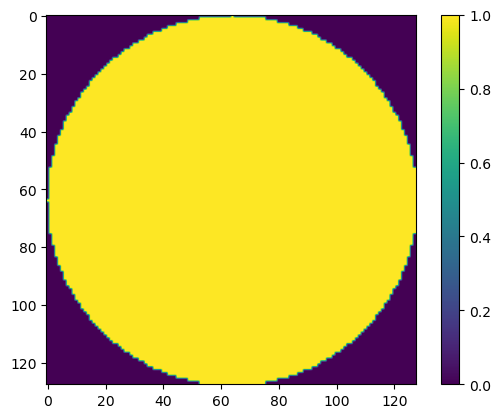

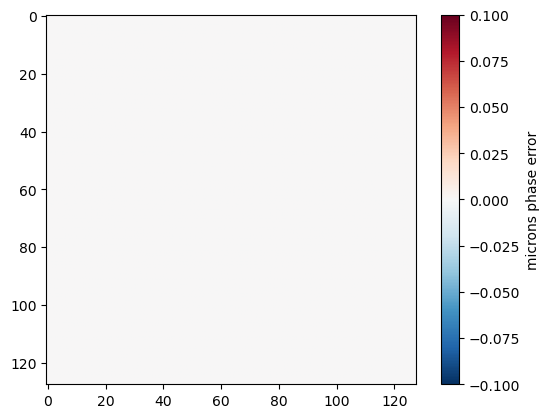

In [18]:
# optical system parameters
epd = IC['pupil_diameter'] # mm
efl = IC['focal_length'] # mm, Keck is F/13 I think
fno = efl / epd
wvl = IC['wavelength'] # um

# build the coordinate grids
x, y = make_xy_grid(128, diameter=epd)
r, t = cart_to_polar(x, y)
dx_p = x[0,1] - x[0,0]

if SEGMENTED_PUPIL:
    # make a keck-like pupil
    cha = CompositeHexagonalAperture(x, y, 3, 1.32e3, 0.007e3, exclude=(0,))

    # set up spiders
    m1 = spider(1, .1e3, x, y, rotation=-120)
    m2 = spider(1, .1e3, x, y, rotation=-60)
    m3 = spider(1, .1e3, x, y, rotation=90)
    spider_ = m1&m2&m3
    A = cha.amp & spider_

else:
    A = circle(epd / 2, r)

plt.figure()
plt.imshow(A)
plt.colorbar()
plt.show()

# construct a polynomial basis to generate wavefront error
r_z = r / (epd / 2) # normalized radius
nms = [noll_to_nm(j) for j in range(2, 37)]
coefs = np.random.random(len(nms))
basis = list(zernike_nm_sequence(nms, r, t, norm=True))
basis_norm = [b / np.max(np.abs(b)) for b in basis]
phs = sum_of_2d_modes(basis_norm, coefs) * 0/5
amp = A

plt.figure()
plt.imshow(phs * amp, cmap='RdBu_r')
plt.colorbar(label='microns phase error')
plt.show()

# Propagate to focus
# NOTE: Phase should be in nm, wvl should be in microns, dx_p should be in mm
# NOTE: WAVEFRONT AND FOCUS_FIXED_SAMPLING HAVE DIFFERENT NORMALIZATIONS AND THROW OFF THE ALGORITHM
k = 2 * np.pi / wvl # enforces phs in microns
wf = amp * np.exp(1j * k * phs)

def prop_to_focus(wavefunction, defocus_waves=0):

    # configure the defocus polynomial
    focus_polynomial = hopkins(0, 2, 0, r_z, t, 0) * defocus_waves
    defocus_aberration = amp * np.exp(-1j * 2 * np.pi * focus_polynomial)


    psf = focus_fixed_sampling(wavefunction=wavefunction * defocus_aberration,
                            input_dx=dx_p,
                            prop_dist=efl,
                            wavelength=wvl,
                            output_dx=IC['image_dx'],
                            output_samples=128)
    psf0 = np.abs(psf)**2
    return psf0

psf0 = prop_to_focus(wf, defocus_waves=0)
psf1 = prop_to_focus(wf, defocus_waves=1)
psf2 = prop_to_focus(wf, defocus_waves=2)
psf3 = prop_to_focus(wf, defocus_waves=3)

In [4]:
help(thinlens.defocus_to_image_displacement)

Help on function defocus_to_image_displacement in module prysm.thinlens:

defocus_to_image_displacement(W020, fno, wavelength=None)
    Compute image displacment from wavefront defocus expressed in waves 0-P to.
    
    Parameters
    ----------
    W020 : float or numpy.ndarray
        wavefront defocus, units of waves if wavelength != None, else units of length
    fno : float
        f/# of the lens or system
    wavelength : float, optional
        wavelength of light, if None W020 takes units of length
    
    Returns
    -------
    float
        image displacement.  Motion of image in um caused by defocus OPD



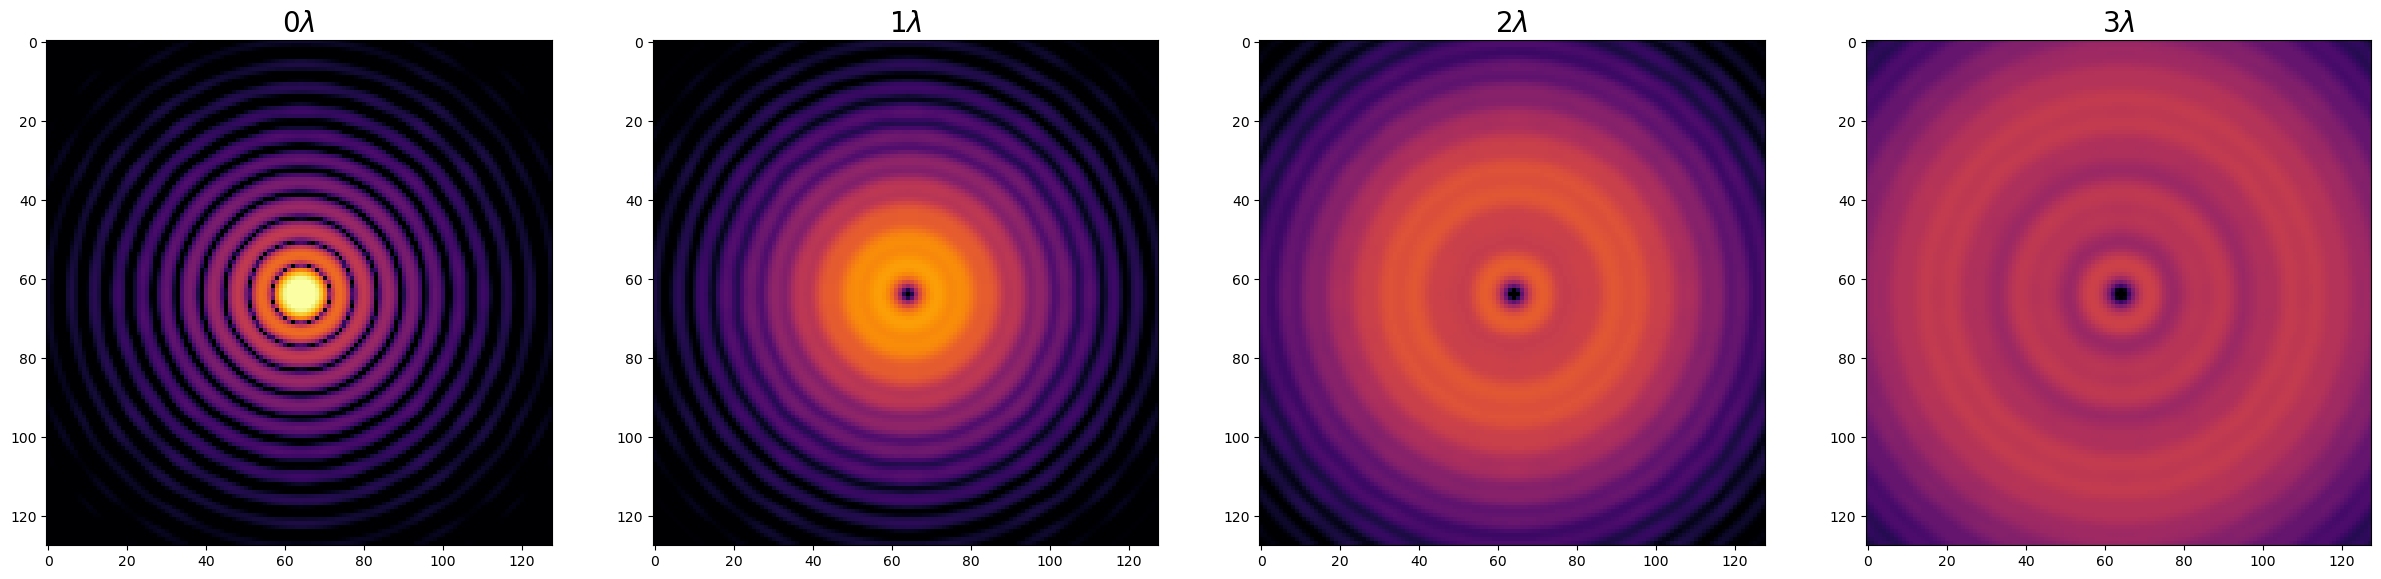

In [19]:
psflist = [psf0, psf1, psf2, psf3]
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(psflist,axs,titles):
    ax.set_title(title,fontsize=20)
    # _psf /= np.max(_psf)
    ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-2)
plt.show()

In [6]:
import poi
# adpr = poi.ADPhaseRetrieval(amp, psf0, IC, basis_norm, defocus=0)
adpr = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[0], IC['image_dx'])

In [7]:
adpr.fwd(np.zeros(len(coefs)))

805933.1904535987

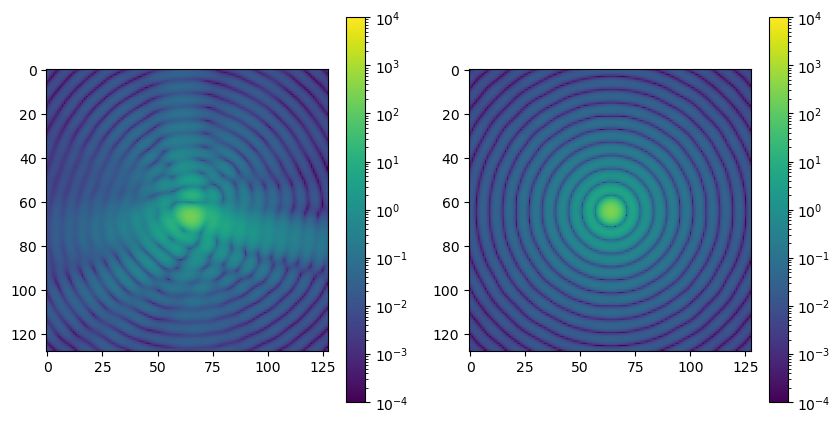

In [8]:
from matplotlib.colors import LogNorm
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.imshow(adpr.D, norm=LogNorm(vmin=1e-4,vmax=1e4))
plt.colorbar()
plt.subplot(122)
plt.imshow(adpr.I, norm=LogNorm(vmin=1e-4,vmax=1e4))
plt.colorbar()
plt.show()


In [9]:
from scipy.optimize import minimize
results = minimize(adpr.fg, x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05933D+05    |proj g|=  4.95246D+06

At iterate    1    f=  1.45788D+05    |proj g|=  7.71774D+05

At iterate    2    f=  1.32979D+05    |proj g|=  1.11030D+05

At iterate    3    f=  1.32607D+05    |proj g|=  6.61378D+04

At iterate    4    f=  1.32240D+05    |proj g|=  7.40489D+04

At iterate    5    f=  1.20968D+05    |proj g|=  1.21494D+06

At iterate    6    f=  1.18168D+05    |proj g|=  1.44677D+06

At iterate    7    f=  1.06411D+05    |proj g|=  1.70065D+06

At iterate    8    f=  8.10085D+04    |proj g|=  1.43737D+06

At iterate    9    f=  3.00946D+04    |proj g|=  2.77159D+05

At iterate   10    f=  2.70441D+04    |proj g|=  8.08045D+04

At iterate   11    f=  2.53078D+04    |proj g|=  3.04592D+04

At iterate   12    f=  1.67009D+04    |proj g|=  1.26314D+05


 This problem is unconstrained.



At iterate   13    f=  1.61069D+04    |proj g|=  1.60129D+05

At iterate   14    f=  1.42569D+04    |proj g|=  7.78838D+04

At iterate   15    f=  8.61657D+03    |proj g|=  1.32506D+05

At iterate   16    f=  5.78129D+03    |proj g|=  5.11278D+04

At iterate   17    f=  5.14183D+03    |proj g|=  1.18720D+05

At iterate   18    f=  3.90395D+03    |proj g|=  3.22353D+04

At iterate   19    f=  3.50666D+03    |proj g|=  2.75498D+04

At iterate   20    f=  1.95409D+03    |proj g|=  3.39739D+04

At iterate   21    f=  1.50597D+03    |proj g|=  5.93891D+04

At iterate   22    f=  1.27781D+03    |proj g|=  3.02048D+04

At iterate   23    f=  1.24045D+03    |proj g|=  5.13010D+03

At iterate   24    f=  1.22700D+03    |proj g|=  5.81224D+03

At iterate   25    f=  1.19158D+03    |proj g|=  7.63253D+03

At iterate   26    f=  1.08049D+03    |proj g|=  9.62496D+03

At iterate   27    f=  9.68842D+02    |proj g|=  3.60843D+04

At iterate   28    f=  8.26378D+02    |proj g|=  2.30502D+04

At iter

In [10]:
print(results)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.028140721973184783
        x: [ 1.349e-01  1.752e-01 ...  1.809e-01  1.133e-01]
      nit: 13593
      jac: [ 8.431e-05  7.381e-02 ... -3.447e-03 -1.819e-04]
     nfev: 15002
     njev: 15002
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>


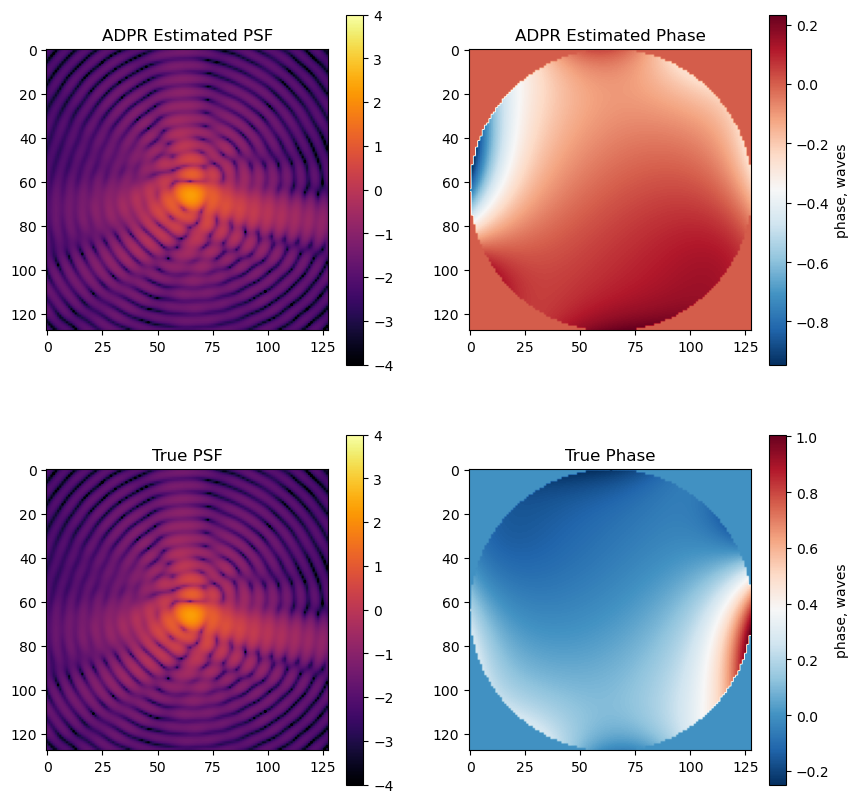

In [11]:
test_vector = np.zeros_like(coefs)
test_vector[2] = 2
k = 2 * np.pi / wvl
E = adpr.fwd(results.x)

plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(adpr.I), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(adpr.W * amp / k, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(adpr.D), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phs * amp / (wvl), cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

In [12]:
adpr1 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[1], IC['image_dx'], defocus_waves=1)

In [13]:
results = minimize(adpr1.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-17, 'gtol': 1e-17, 'disp': 1})

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60977D+04    |proj g|=  6.38651D+04

At iterate    1    f=  2.92258D+04    |proj g|=  3.50680D+04

At iterate    2    f=  2.18256D+04    |proj g|=  5.81224D+04

At iterate    3    f=  1.37845D+04    |proj g|=  5.46791D+04

At iterate    4    f=  9.71522D+03    |proj g|=  4.11894D+04

At iterate    5    f=  7.22703D+03    |proj g|=  3.92636D+04

At iterate    6    f=  4.61252D+03    |proj g|=  2.92490D+04

At iterate    7    f=  3.51417D+03    |proj g|=  1.03884D+04

At iterate    8    f=  2.94444D+03    |proj g|=  8.17553D+03

At iterate    9    f=  1.77497D+03    |proj g|=  9.57977D+03

At iterate   10    f=  1.34820D+03    |proj g|=  1.66543D+04

At iterate   11    f=  9.73718D+02    |proj g|=  4.57110D+03

At iterate   12    f=  8.06341D+02    |proj g|=  5.71584D+03

At iterate   13    f=  5.5

/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_40784/3138656705.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(phase_est / amp, cmap='RdBu_r')
/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_40784/3138656705.py:28: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(phase_truth / amp, cmap='RdBu_r')


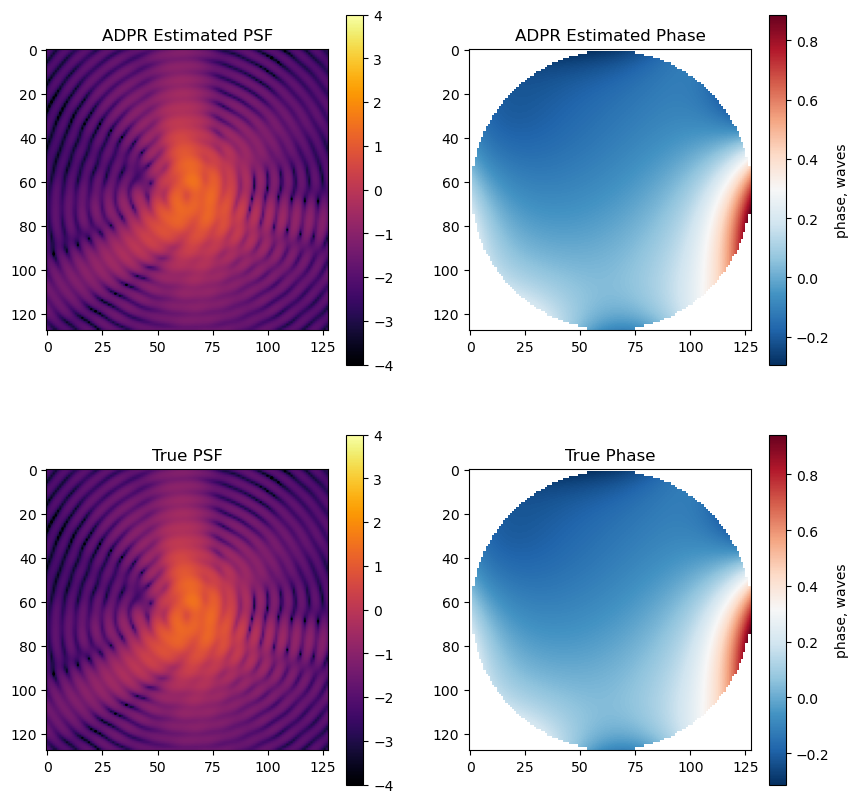

In [14]:
test_vector = np.zeros_like(coefs)
test_vector[2] = 0
k = 2 * np.pi / wvl
E = adpr.fwd(results.x)

phase_est = adpr1.phs
phase_est -= np.mean(phase_est[amp==1])

phase_truth = phs / (wvl)
phase_truth -= np.mean(phase_truth[amp==1])


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(adpr1.I), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est / amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(adpr1.D), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth / amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

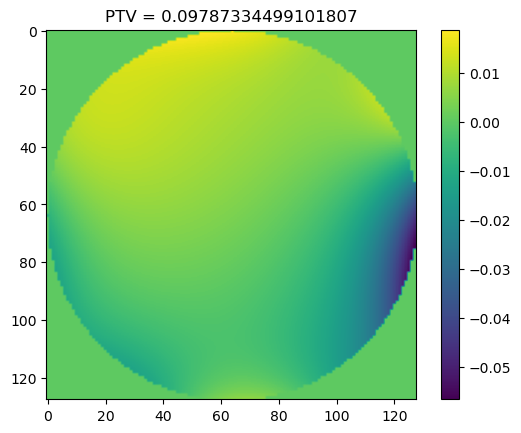

In [15]:
phase_diff = phase_est - phase_truth
plt.figure()
plt.title(f'PTV = {phase_diff.max() - phase_diff.min()}')
plt.imshow(phase_diff * amp)
plt.colorbar()
# 0.65, 2, positive in middle
# , 1

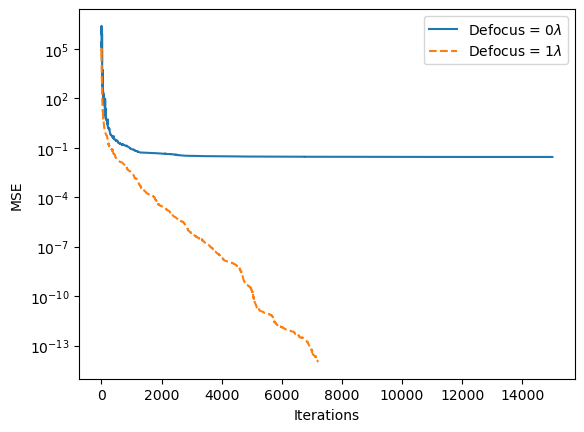

In [123]:
plt.plot()
plt.plot(adpr.cost, label='Defocus = '+r'$0\lambda$')
plt.plot(adpr1.cost, label='Defocus = '+r'$1\lambda$', linestyle='dashed')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

# And now we try focus diversity

In [124]:
# configure the individual optimizers
adpr0 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[1], IC['image_dx'], defocus_waves=1)

# set up the net optimizer
optlist = [adpr0, adpr1]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

In [125]:
results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-17, 'gtol': 1e-17, 'disp': 1})

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52031D+05    |proj g|=  5.01632D+06

At iterate    1    f=  1.83968D+05    |proj g|=  8.11789D+05

At iterate    2    f=  1.68991D+05    |proj g|=  1.28116D+05

At iterate    3    f=  1.14407D+05    |proj g|=  1.43250D+06

At iterate    4    f=  1.10967D+05    |proj g|=  1.55049D+06

At iterate    5    f=  9.41140D+04    |proj g|=  1.44702D+06

At iterate    6    f=  2.59476D+04    |proj g|=  1.94647D+05

At iterate    7    f=  2.24599D+04    |proj g|=  8.17643D+04

At iterate    8    f=  2.11441D+04    |proj g|=  7.61663D+04

At iterate    9    f=  1.16268D+04    |proj g|=  3.71526D+05

At iterate   10    f=  8.37138D+03    |proj g|=  2.32687D+05

At iterate   11    f=  6.20875D+03    |proj g|=  2.02009D+04

At iterate   12    f=  6.06168D+03    |proj g|=  2.53043D+04

At iterate   13    f=  5.1

In [126]:
print(results)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 1.2982292201526984e-12
        x: [ 1.348e-01  1.754e-01 ...  1.823e-01  1.128e-01]
      nit: 13699
      jac: [ 8.199e-05 -8.399e-05 ...  1.397e-05  9.506e-06]
     nfev: 15001
     njev: 15001
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>


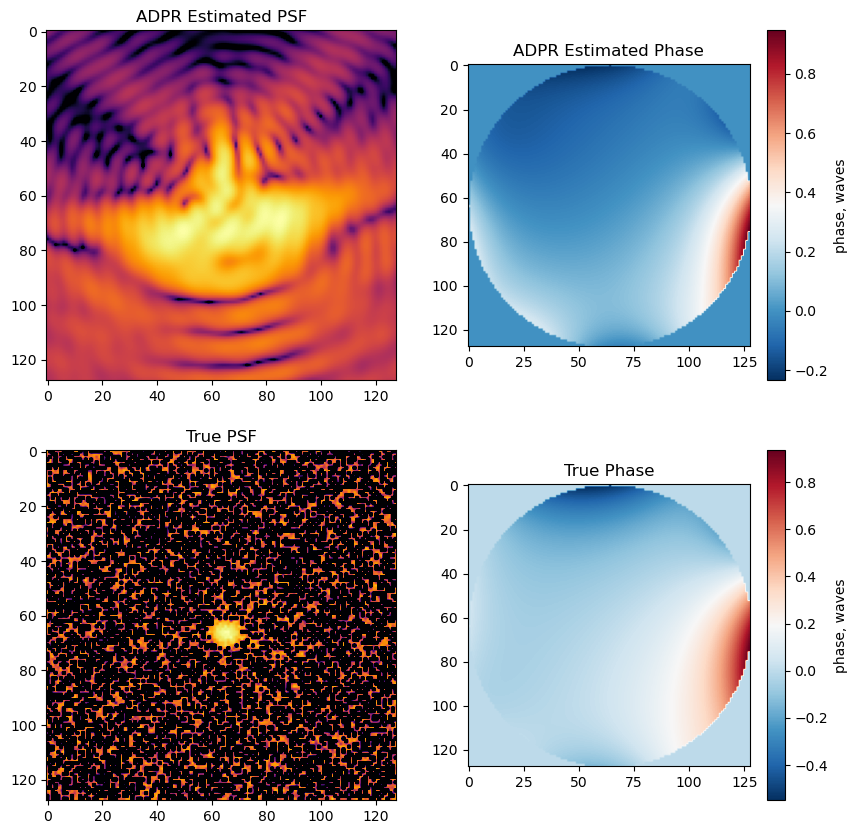

In [137]:
k = 2 * np.pi / wvl

psf_est = fdpr.optlist[0].I
psf_est /= psf_est.max()
psf_truth = fdpr.optlist[0].D
psf_truth /= psf_truth.max()

phase_est = sum_of_2d_modes(basis_norm, results.x)
phase_truth = phs


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(psf_est), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(psf_truth), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

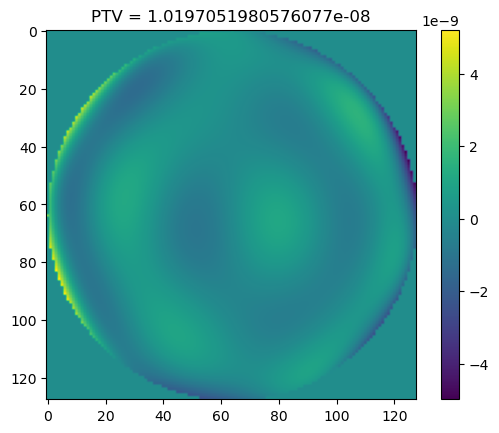

In [128]:
phase_diff = phase_est - phase_truth
phase_diff -= np.mean(phase_diff[amp==1])
plt.figure()
plt.title(f'PTV = {phase_diff[amp==1].max() - phase_diff[amp==1].min()}')
plt.imshow(phase_diff * amp)
plt.colorbar()

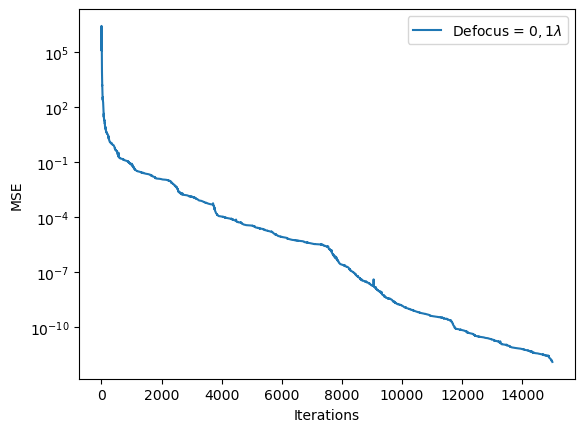

In [129]:
plt.plot()
plt.plot(fdpr.cost, label='Defocus = '+r'$0, 1\lambda$')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

# Try with poisson noisy data

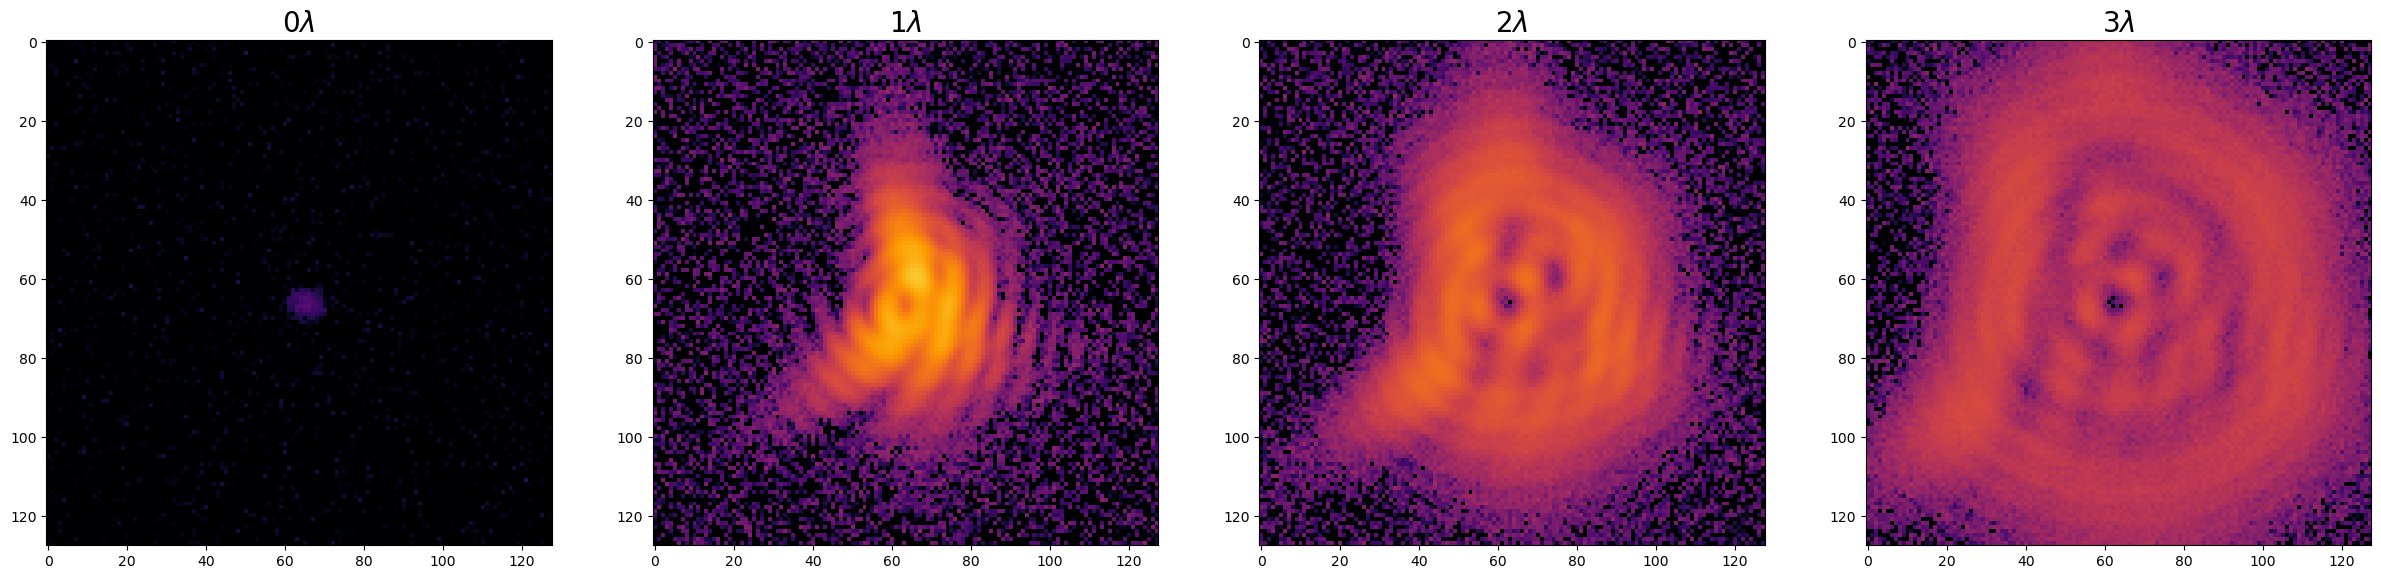

In [136]:
noisy_psfs = [np.random.normal(p, scale=1e-1) for p in psflist]
# mask them
for i, p in enumerate(noisy_psfs):
    p[p <= 1e-5] = 1e-20
    noisy_psfs[i] = p

for i, pnom in enumerate(psflist):
    energy_nom = np.sum(pnom)
    energy_noisy = np.sum(noisy_psfs[i])
    noisy_psfs[i] *=  (energy_nom / energy_noisy)

titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(noisy_psfs,axs,titles):
    ax.set_title(title,fontsize=20)
    ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-2)
plt.show()

In [131]:
# configure the individual optimizers
adpr0 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, noisy_psfs[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, noisy_psfs[1], IC['image_dx'], defocus_waves=1)

# set up the net optimizer
optlist = [adpr0, adpr1]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

In [132]:
results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'disp': 1})

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71518D+06    |proj g|=  6.41860D+04

At iterate    1    f=  1.34730D+05    |proj g|=  2.87809D+04

At iterate    2    f=  1.24653D+05    |proj g|=  2.57201D+03

At iterate    3    f=  1.04331D+05    |proj g|=  4.37554D+03

At iterate    4    f=  1.04170D+05    |proj g|=  3.54323D+03

At iterate    5    f=  1.03638D+05    |proj g|=  3.34492D+03

At iterate    6    f=  1.00905D+05    |proj g|=  1.01317D+04

At iterate    7    f=  9.91398D+04    |proj g|=  3.64373D+03

At iterate    8    f=  9.78725D+04    |proj g|=  5.14735D+03

At iterate    9    f=  9.63208D+04    |proj g|=  2.15240D+04

At iterate   10    f=  9.28845D+04    |proj g|=  1.09648D+04

At iterate   11    f=  8.97367D+04    |proj g|=  3.66855D+03

At iterate   12    f=  8.83824D+04    |proj g|=  1.24638D+04

At iterate   13    f=  8.6

Traceback (most recent call last):
  File "/Users/work/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_36395/1585674390.py", line 1, in <module>
    results = minimize(fdpr.fg,
              ^^^^^^^^^^^^^^^^^
  File "/Users/work/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py", line 710, in minimize
    res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/work/anaconda3/lib/python3.11/site-packages/scipy/optimize/_lbfgsb_py.py", line 361, in _minimize_lbfgsb
    f, g = func_and_grad(x)
           ^^^^^^^^^^^^^^^^
  File "/Users/work/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 285, in fun_and_grad
    self._update_fun()
  File "/Users/work/anaconda3/lib/python3.11/site-packages/scipy/optim

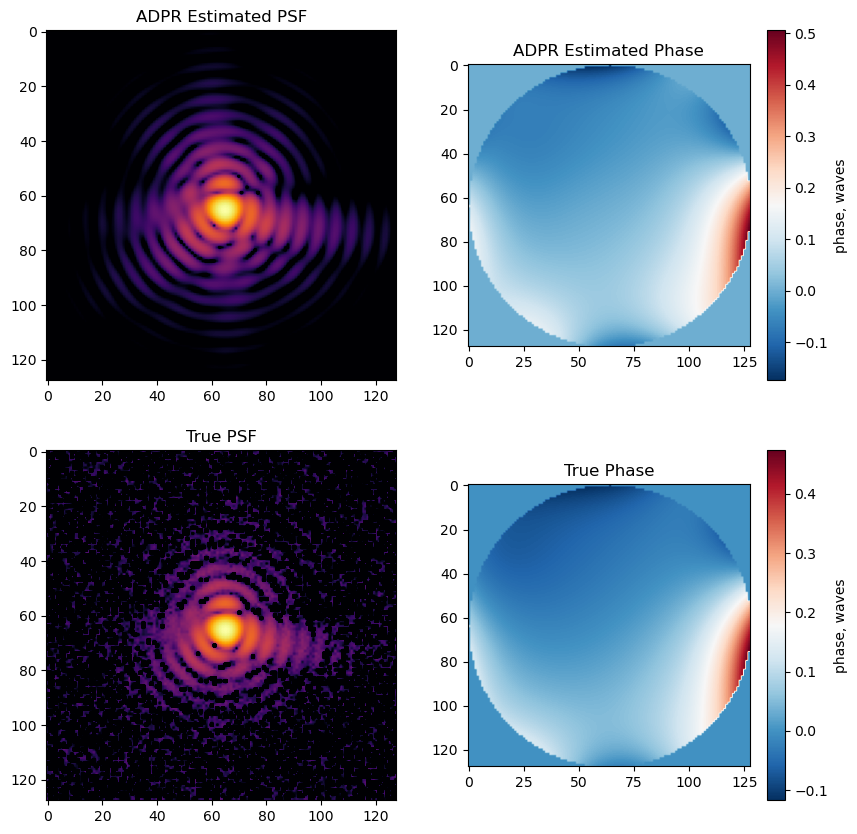

In [ ]:
k = 2 * np.pi / wvl

psf_est = fdpr.optlist[0].I
psf_est /= psf_est.max()
psf_truth = fdpr.optlist[0].D
psf_truth /= psf_truth.max()

phase_est = sum_of_2d_modes(basis_norm, results.x)
phase_truth = phs


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(psf_est), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(psf_truth), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()